# Feature Engineering for Procurement Anomaly Detection

**Purpose:** Transform raw procurement data into ML-ready features that capture corruption patterns.

**Feature Categories:**
1. **Price Features** - Deviations from regional/category medians, price changes
2. **Competition Features** - Bidder counts, market concentration, win rates
3. **Temporal Features** - Deadline pressure, seasonal patterns, budget cycles
4. **Network Features** - Supplier-organizer relationships, centrality measures
5. **Geographic Features** - Cross-region activity, distance patterns

**Goal:** Create comprehensive feature set for unsupervised and supervised anomaly detection models.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pathlib import Path
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Load and Merge Data

In [2]:
# Load datasets
data_dir = Path('../data/raw')

print("Loading datasets...")
df_suppliers = pd.read_csv(data_dir / 'Suppliers.csv', low_memory=False)
df_procurements = pd.read_csv(data_dir / 'Competitive_procurements.csv', low_memory=False)

print(f"✓ Suppliers: {len(df_suppliers):,} rows")
print(f"✓ Procurements: {len(df_procurements):,} rows")

# Display columns for reference
print("\nSuppliers columns:")
print(df_suppliers.columns.tolist())

Loading datasets...
✓ Suppliers: 3,621,822 rows
✓ Procurements: 2,313,168 rows

Suppliers columns:
['lot_announce_date', 'lot_announce_year', 'organizer_name', 'organizer_code', 'organizer_region', 'lot_id', 'lot_procur_type', 'lot_competitiveness', 'lot_cpv', 'lot_cpv_4_digs', 'lot_cpv_2_digs', 'lot_initial_value', 'lot_final_value', 'supplier_name', 'supplier_code', 'supplier_region']


In [3]:
# Parse date columns
date_columns = [col for col in df_suppliers.columns if 'date' in col.lower()]
print(f"Found date columns: {date_columns}")

for col in date_columns[:5]:  # Limit to first 5
    try:
        df_suppliers[col] = pd.to_datetime(df_suppliers[col], errors='coerce')
        print(f"✓ Converted {col}")
    except:
        print(f"⚠ Failed: {col}")

Found date columns: ['lot_announce_date']
✓ Converted lot_announce_date


In [4]:
# Calculate bidder counts and merge
if 'lot_id' in df_procurements.columns:
    print("\nCalculating competition metrics...")
    
    # Count bidders per lot
    bidders_per_lot = df_procurements.groupby('lot_id').size().reset_index(name='bidder_count')
    
    # Merge with suppliers
    df = df_suppliers.merge(bidders_per_lot, on='lot_id', how='left')
    
    print(f"✓ Merged dataset: {len(df):,} rows")
    print(f"✓ Bidder count added")
else:
    df = df_suppliers.copy()
    print("⚠ No lot_id found, proceeding without bidder counts")


Calculating competition metrics...
✓ Merged dataset: 3,621,822 rows
✓ Bidder count added


## 2. Price-Based Features

Features capturing price anomalies and deviations from expected values.

In [5]:
# Find price columns
price_cols = [col for col in df.columns if any(x in col.lower() for x in ['price', 'amount', 'value', 'cost'])]
print(f"Price columns found: {price_cols}")

# Identify initial and final prices
initial_price_col = None
final_price_col = None

for col in price_cols:
    if any(x in col.lower() for x in ['initial', 'start', 'expected']):
        initial_price_col = col
    if any(x in col.lower() for x in ['final', 'award', 'winner', 'contract']):
        final_price_col = col

print(f"\nInitial price column: {initial_price_col}")
print(f"Final price column: {final_price_col}")

Price columns found: ['lot_initial_value', 'lot_final_value']

Initial price column: lot_initial_value
Final price column: lot_final_value


In [6]:
# Price change features
if initial_price_col and final_price_col:
    print("\nEngineering price change features...")
    
    # Absolute and percentage change
    df['price_change_abs'] = df[final_price_col] - df[initial_price_col]
    df['price_change_pct'] = (df['price_change_abs'] / df[initial_price_col] * 100).replace([np.inf, -np.inf], np.nan)
    
    # Binary flags
    df['price_increased'] = (df['price_change_abs'] > 0).astype(int)
    df['price_decreased'] = (df['price_change_abs'] < 0).astype(int)
    df['price_unchanged'] = (df['price_change_abs'] == 0).astype(int)
    
    # Extreme changes (>20% or <-20%)
    df['price_extreme_increase'] = (df['price_change_pct'] > 20).astype(int)
    df['price_extreme_decrease'] = (df['price_change_pct'] < -20).astype(int)
    
    print("✓ Price change features created")
    print(f"  - price_change_abs, price_change_pct")
    print(f"  - Binary flags: increased, decreased, unchanged, extreme changes")


Engineering price change features...
✓ Price change features created
  - price_change_abs, price_change_pct
  - Binary flags: increased, decreased, unchanged, extreme changes


In [7]:
# Regional price benchmarks
region_cols = [col for col in df.columns if any(x in col.lower() for x in ['region', 'oblast', 'area'])]
cpv_cols = [col for col in df.columns if 'cpv' in col.lower() or 'categor' in col.lower()]

if final_price_col and region_cols:
    region_col = region_cols[0]
    
    print(f"\nCalculating regional price benchmarks using: {region_col}")
    
    # Regional statistics
    regional_stats = df.groupby(region_col)[final_price_col].agg(['mean', 'median', 'std'])
    regional_stats.columns = ['regional_mean_price', 'regional_median_price', 'regional_std_price']
    
    # Merge back
    df = df.merge(regional_stats, left_on=region_col, right_index=True, how='left')
    
    # Calculate deviations
    df['price_vs_regional_median'] = df[final_price_col] - df['regional_median_price']
    df['price_vs_regional_median_pct'] = (df['price_vs_regional_median'] / df['regional_median_price'] * 100).replace([np.inf, -np.inf], np.nan)
    
    # Z-score (how many standard deviations from regional mean)
    df['price_zscore_regional'] = ((df[final_price_col] - df['regional_mean_price']) / df['regional_std_price']).replace([np.inf, -np.inf], np.nan)
    
    # Flag extreme outliers (>3 std deviations)
    df['price_outlier_regional'] = (np.abs(df['price_zscore_regional']) > 3).astype(int)
    
    print("✓ Regional price features created")
    print(f"  - Deviations from regional median (absolute and percentage)")
    print(f"  - Z-scores and outlier flags")


Calculating regional price benchmarks using: organizer_region
✓ Regional price features created
  - Deviations from regional median (absolute and percentage)
  - Z-scores and outlier flags


In [8]:
# Category price benchmarks
if final_price_col and cpv_cols:
    cpv_col = cpv_cols[0]
    
    print(f"\nCalculating category price benchmarks using: {cpv_col}")
    
    # Category statistics
    category_stats = df.groupby(cpv_col)[final_price_col].agg(['mean', 'median', 'std'])
    category_stats.columns = ['category_mean_price', 'category_median_price', 'category_std_price']
    
    # Merge back
    df = df.merge(category_stats, left_on=cpv_col, right_index=True, how='left')
    
    # Calculate deviations
    df['price_vs_category_median'] = df[final_price_col] - df['category_median_price']
    df['price_vs_category_median_pct'] = (df['price_vs_category_median'] / df['category_median_price'] * 100).replace([np.inf, -np.inf], np.nan)
    
    # Z-score
    df['price_zscore_category'] = ((df[final_price_col] - df['category_mean_price']) / df['category_std_price']).replace([np.inf, -np.inf], np.nan)
    
    # Flag outliers
    df['price_outlier_category'] = (np.abs(df['price_zscore_category']) > 3).astype(int)
    
    print("✓ Category price features created")
    print(f"  - Deviations from category median (absolute and percentage)")
    print(f"  - Z-scores and outlier flags")


Calculating category price benchmarks using: lot_cpv
✓ Category price features created
  - Deviations from category median (absolute and percentage)
  - Z-scores and outlier flags


## 3. Competition Features

Features measuring market competition and concentration.

In [9]:
# Basic competition features
if 'bidder_count' in df.columns:
    print("\nEngineering competition features...")
    
    # Binary flags
    df['is_single_bidder'] = (df['bidder_count'] == 1).astype(int)
    df['is_low_competition'] = (df['bidder_count'] <= 2).astype(int)
    df['is_healthy_competition'] = (df['bidder_count'] >= 5).astype(int)
    
    # Competition level categories
    df['competition_level'] = pd.cut(df['bidder_count'], 
                                     bins=[0, 1, 2, 4, 10, 100], 
                                     labels=['single', 'very_low', 'low', 'medium', 'high'])
    
    print("✓ Basic competition features created")
    print(f"  - Binary flags: single bidder, low competition, healthy competition")
    print(f"  - Competition level categories")
    
    # Statistics
    print(f"\nCompetition statistics:")
    print(f"  Single bidder: {df['is_single_bidder'].sum():,} ({df['is_single_bidder'].mean()*100:.2f}%)")
    print(f"  Low competition (≤2): {df['is_low_competition'].sum():,} ({df['is_low_competition'].mean()*100:.2f}%)")
    print(f"  Healthy competition (≥5): {df['is_healthy_competition'].sum():,} ({df['is_healthy_competition'].mean()*100:.2f}%)")


Engineering competition features...
✓ Basic competition features created
  - Binary flags: single bidder, low competition, healthy competition
  - Competition level categories

Competition statistics:
  Single bidder: 298,510 (8.24%)
  Low competition (≤2): 665,365 (18.37%)
  Healthy competition (≥5): 77,616 (2.14%)


In [10]:
# Regional competition benchmarks
if 'bidder_count' in df.columns and region_cols:
    region_col = region_cols[0]
    
    print(f"\nCalculating regional competition benchmarks using: {region_col}")
    
    # Regional competition statistics
    regional_competition = df.groupby(region_col)['bidder_count'].agg(['mean', 'median', 'std'])
    regional_competition.columns = ['regional_avg_bidders', 'regional_median_bidders', 'regional_std_bidders']
    
    # Calculate single bidder rate by region
    regional_single_bidder_rate = df.groupby(region_col)['is_single_bidder'].mean()
    regional_competition['regional_single_bidder_rate'] = regional_single_bidder_rate
    
    # Merge back
    df = df.merge(regional_competition, left_on=region_col, right_index=True, how='left')
    
    # Deviation from regional average
    df['bidders_vs_regional_avg'] = df['bidder_count'] - df['regional_avg_bidders']
    
    # Flag: Is this tender worse than regional average?
    df['below_regional_competition'] = (df['bidder_count'] < df['regional_median_bidders']).astype(int)
    
    print("✓ Regional competition features created")
    print(f"  - Regional average/median bidders")
    print(f"  - Regional single bidder rate")
    print(f"  - Competition comparison flags")


Calculating regional competition benchmarks using: organizer_region
✓ Regional competition features created
  - Regional average/median bidders
  - Regional single bidder rate
  - Competition comparison flags


In [11]:
# Category competition benchmarks
if 'bidder_count' in df.columns and cpv_cols:
    cpv_col = cpv_cols[0]
    
    print(f"\nCalculating category competition benchmarks using: {cpv_col}")
    
    # Category competition statistics
    category_competition = df.groupby(cpv_col)['bidder_count'].agg(['mean', 'median', 'std'])
    category_competition.columns = ['category_avg_bidders', 'category_median_bidders', 'category_std_bidders']
    
    # Single bidder rate by category
    category_single_bidder_rate = df.groupby(cpv_col)['is_single_bidder'].mean()
    category_competition['category_single_bidder_rate'] = category_single_bidder_rate
    
    # Merge back
    df = df.merge(category_competition, left_on=cpv_col, right_index=True, how='left')
    
    # Deviation from category average
    df['bidders_vs_category_avg'] = df['bidder_count'] - df['category_avg_bidders']
    
    # Flag: worse than category average?
    df['below_category_competition'] = (df['bidder_count'] < df['category_median_bidders']).astype(int)
    
    print("✓ Category competition features created")
    print(f"  - Category average/median bidders")
    print(f"  - Category single bidder rate")
    print(f"  - Competition comparison flags")


Calculating category competition benchmarks using: lot_cpv
✓ Category competition features created
  - Category average/median bidders
  - Category single bidder rate
  - Competition comparison flags


In [12]:
# Supplier and organizer win rates
supplier_cols = [col for col in df.columns if any(x in col.lower() for x in ['supplier', 'winner', 'contractor'])]
organizer_cols = [col for col in df.columns if any(x in col.lower() for x in ['organiz', 'buyer', 'customer'])]

if supplier_cols:
    supplier_col = supplier_cols[0]
    
    print(f"\nCalculating supplier statistics using: {supplier_col}")
    
    # Supplier win counts
    supplier_wins = df.groupby(supplier_col).size().to_dict()
    df['supplier_total_wins'] = df[supplier_col].map(supplier_wins)
    
    # Supplier average bidder count (when they win)
    if 'bidder_count' in df.columns:
        supplier_avg_competition = df.groupby(supplier_col)['bidder_count'].mean().to_dict()
        df['supplier_avg_competition'] = df[supplier_col].map(supplier_avg_competition)
        
        # How often does this supplier win with single bidder?
        supplier_single_bidder_rate = df.groupby(supplier_col)['is_single_bidder'].mean().to_dict()
        df['supplier_single_bidder_rate'] = df[supplier_col].map(supplier_single_bidder_rate)
    
    print("✓ Supplier features created")
    print(f"  - Total wins, average competition, single bidder rate")

if organizer_cols:
    organizer_col = organizer_cols[0]
    
    print(f"\nCalculating organizer statistics using: {organizer_col}")
    
    # Organizer tender counts
    organizer_tenders = df.groupby(organizer_col).size().to_dict()
    df['organizer_total_tenders'] = df[organizer_col].map(organizer_tenders)
    
    # Organizer average competition
    if 'bidder_count' in df.columns:
        organizer_avg_competition = df.groupby(organizer_col)['bidder_count'].mean().to_dict()
        df['organizer_avg_competition'] = df[organizer_col].map(organizer_avg_competition)
        
        # Organizer single bidder rate
        organizer_single_bidder_rate = df.groupby(organizer_col)['is_single_bidder'].mean().to_dict()
        df['organizer_single_bidder_rate'] = df[organizer_col].map(organizer_single_bidder_rate)
    
    print("✓ Organizer features created")
    print(f"  - Total tenders, average competition, single bidder rate")


Calculating supplier statistics using: supplier_name
✓ Supplier features created
  - Total wins, average competition, single bidder rate

Calculating organizer statistics using: organizer_name
✓ Organizer features created
  - Total tenders, average competition, single bidder rate


## 4. Temporal Features

Features capturing time-based patterns and deadline pressure.

In [13]:
# Extract temporal features from date columns
if date_columns:
    primary_date_col = date_columns[0]
    
    print(f"\nEngineering temporal features using: {primary_date_col}")
    
    # Basic temporal features
    df['year'] = df[primary_date_col].dt.year
    df['month'] = df[primary_date_col].dt.month
    df['quarter'] = df[primary_date_col].dt.quarter
    df['day_of_week'] = df[primary_date_col].dt.dayofweek
    df['day_of_month'] = df[primary_date_col].dt.day
    df['week_of_year'] = df[primary_date_col].dt.isocalendar().week
    
    # Binary flags
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_end_of_month'] = (df['day_of_month'] >= 25).astype(int)
    df['is_q4'] = (df['quarter'] == 4).astype(int)  # Budget cycle pressure
    df['is_december'] = (df['month'] == 12).astype(int)  # Year-end rush
    
    print("✓ Basic temporal features created")
    print(f"  - Year, month, quarter, day of week/month")
    print(f"  - Binary flags: weekend, end of month, Q4, December")
    
    # Statistics
    print(f"\nTemporal statistics:")
    print(f"  Q4 tenders: {df['is_q4'].sum():,} ({df['is_q4'].mean()*100:.2f}%)")
    print(f"  December tenders: {df['is_december'].sum():,} ({df['is_december'].mean()*100:.2f}%)")
    print(f"  End-of-month tenders: {df['is_end_of_month'].sum():,} ({df['is_end_of_month'].mean()*100:.2f}%)")


Engineering temporal features using: lot_announce_date
✓ Basic temporal features created
  - Year, month, quarter, day of week/month
  - Binary flags: weekend, end of month, Q4, December

Temporal statistics:
  Q4 tenders: 1,223,166 (33.77%)
  December tenders: 505,599 (13.96%)
  End-of-month tenders: 711,106 (19.63%)


In [14]:
# Deadline pressure features (if we have tender start and end dates)
tender_start_cols = [col for col in date_columns if any(x in col.lower() for x in ['start', 'publish', 'announc'])]
tender_end_cols = [col for col in date_columns if any(x in col.lower() for x in ['end', 'deadline', 'close'])]

if tender_start_cols and tender_end_cols:
    start_col = tender_start_cols[0]
    end_col = tender_end_cols[0]
    
    print(f"\nCalculating deadline pressure features...")
    print(f"  Start: {start_col}")
    print(f"  End: {end_col}")
    
    # Calculate tender duration in days
    df['tender_duration_days'] = (df[end_col] - df[start_col]).dt.days
    
    # Flag very short tenders (potential red flag)
    df['is_rush_tender'] = (df['tender_duration_days'] <= 7).astype(int)
    df['is_very_rush_tender'] = (df['tender_duration_days'] <= 3).astype(int)
    
    print("✓ Deadline pressure features created")
    print(f"  - Tender duration in days")
    print(f"  - Rush tender flags (≤7 days, ≤3 days)")
    
    # Statistics
    print(f"\nDeadline statistics:")
    print(f"  Average duration: {df['tender_duration_days'].mean():.2f} days")
    print(f"  Rush tenders (≤7 days): {df['is_rush_tender'].sum():,} ({df['is_rush_tender'].mean()*100:.2f}%)")
    print(f"  Very rush (≤3 days): {df['is_very_rush_tender'].sum():,} ({df['is_very_rush_tender'].mean()*100:.2f}%)")

## 5. Network Features

Features based on supplier-organizer relationship networks.

In [15]:
# Supplier-Organizer relationships
if supplier_cols and organizer_cols:
    supplier_col = supplier_cols[0]
    organizer_col = organizer_cols[0]
    
    print(f"\nAnalyzing supplier-organizer network...")
    print(f"  Supplier: {supplier_col}")
    print(f"  Organizer: {organizer_col}")
    
    # How many times has this supplier won from this organizer?
    supplier_organizer_wins = df.groupby([supplier_col, organizer_col]).size().reset_index(name='supplier_organizer_win_count')
    df = df.merge(supplier_organizer_wins, on=[supplier_col, organizer_col], how='left')
    
    # What percentage of supplier's total wins are from this organizer?
    df['supplier_organizer_concentration'] = (df['supplier_organizer_win_count'] / df['supplier_total_wins']).fillna(0)
    
    # Flag: supplier heavily dependent on one organizer (potential collusion)
    df['supplier_high_concentration'] = (df['supplier_organizer_concentration'] > 0.5).astype(int)
    
    # How many unique organizers has this supplier won from?
    supplier_organizer_diversity = df.groupby(supplier_col)[organizer_col].nunique().to_dict()
    df['supplier_organizer_diversity'] = df[supplier_col].map(supplier_organizer_diversity)
    
    # How many unique suppliers has this organizer used?
    organizer_supplier_diversity = df.groupby(organizer_col)[supplier_col].nunique().to_dict()
    df['organizer_supplier_diversity'] = df[organizer_col].map(organizer_supplier_diversity)
    
    print("✓ Network relationship features created")
    print(f"  - Supplier-organizer win counts")
    print(f"  - Concentration/dependency metrics")
    print(f"  - Diversity metrics (unique partners)")
    
    # Statistics
    print(f"\nNetwork statistics:")
    print(f"  High concentration pairs: {df['supplier_high_concentration'].sum():,} ({df['supplier_high_concentration'].mean()*100:.2f}%)")
    print(f"  Avg supplier diversity: {df['supplier_organizer_diversity'].mean():.2f} organizers")
    print(f"  Avg organizer diversity: {df['organizer_supplier_diversity'].mean():.2f} suppliers")


Analyzing supplier-organizer network...
  Supplier: supplier_name
  Organizer: organizer_name
✓ Network relationship features created
  - Supplier-organizer win counts
  - Concentration/dependency metrics
  - Diversity metrics (unique partners)

Network statistics:
  High concentration pairs: 1,001,347 (27.65%)
  Avg supplier diversity: 154.72 organizers
  Avg organizer diversity: 184.52 suppliers


In [16]:
# Build simple network graph (sample for demonstration)
if supplier_cols and organizer_cols:
    print("\nBuilding network graph (sample: 10,000 tenders)...")
    
    # Sample for network analysis (full graph would be too large)
    df_sample = df.head(10000)
    
    # Create bipartite graph
    G = nx.Graph()
    
    for _, row in df_sample.iterrows():
        supplier = row[supplier_col]
        organizer = row[organizer_col]
        
        if pd.notna(supplier) and pd.notna(organizer):
            if G.has_edge(supplier, organizer):
                G[supplier][organizer]['weight'] += 1
            else:
                G.add_edge(supplier, organizer, weight=1)
    
    print(f"✓ Network graph built")
    print(f"  Nodes: {G.number_of_nodes():,}")
    print(f"  Edges: {G.number_of_edges():,}")
    
    # Calculate centrality measures (for sample)
    print("\nCalculating network centrality (this may take a moment)...")
    
    try:
        degree_centrality = nx.degree_centrality(G)
        betweenness_centrality = nx.betweenness_centrality(G, k=min(100, G.number_of_nodes()))
        
        # Map back to dataframe (sample only)
        df_sample['supplier_degree_centrality'] = df_sample[supplier_col].map(degree_centrality)
        df_sample['supplier_betweenness_centrality'] = df_sample[supplier_col].map(betweenness_centrality)
        
        print("✓ Centrality measures calculated (for sample)")
        print("  Note: For production, calculate centrality on full dataset and merge")
    except:
        print("⚠ Centrality calculation skipped (network too large or complex)")


Building network graph (sample: 10,000 tenders)...
✓ Network graph built
  Nodes: 3,779
  Edges: 6,413

Calculating network centrality (this may take a moment)...
✓ Centrality measures calculated (for sample)
  Note: For production, calculate centrality on full dataset and merge


## 6. Geographic Features

Features based on regional patterns and cross-region activity.

In [17]:
# Cross-region activity
if region_cols and supplier_cols:
    region_col = region_cols[0]
    supplier_col = supplier_cols[0]
    
    print(f"\nAnalyzing geographic patterns...")
    print(f"  Region: {region_col}")
    print(f"  Supplier: {supplier_col}")
    
    # How many regions does this supplier operate in?
    supplier_region_count = df.groupby(supplier_col)[region_col].nunique().to_dict()
    df['supplier_region_count'] = df[supplier_col].map(supplier_region_count)
    
    # Flag: multi-region suppliers (normal for large companies, suspicious for small ones)
    df['supplier_multi_region'] = (df['supplier_region_count'] > 1).astype(int)
    df['supplier_many_regions'] = (df['supplier_region_count'] > 5).astype(int)
    
    # Regional market share (for this supplier)
    regional_tender_counts = df.groupby(region_col).size().to_dict()
    supplier_region_wins = df.groupby([supplier_col, region_col]).size().reset_index(name='regional_wins')
    df = df.merge(supplier_region_wins, on=[supplier_col, region_col], how='left')
    
    df['regional_tender_total'] = df[region_col].map(regional_tender_counts)
    df['supplier_regional_market_share'] = (df['regional_wins'] / df['regional_tender_total']).fillna(0)
    
    # Flag: high regional market share (potential monopoly)
    df['supplier_regional_dominance'] = (df['supplier_regional_market_share'] > 0.1).astype(int)  # >10% of region
    
    print("✓ Geographic features created")
    print(f"  - Supplier region count and diversity")
    print(f"  - Regional market share")
    print(f"  - Dominance flags")
    
    # Statistics
    print(f"\nGeographic statistics:")
    print(f"  Multi-region suppliers: {df['supplier_multi_region'].sum():,} tenders ({df['supplier_multi_region'].mean()*100:.2f}%)")
    print(f"  Regional dominance: {df['supplier_regional_dominance'].sum():,} tenders ({df['supplier_regional_dominance'].mean()*100:.2f}%)")


Analyzing geographic patterns...
  Region: organizer_region
  Supplier: supplier_name
✓ Geographic features created
  - Supplier region count and diversity
  - Regional market share
  - Dominance flags

Geographic statistics:
  Multi-region suppliers: 1,904,726 tenders (52.59%)
  Regional dominance: 0 tenders (0.00%)


## 7. Composite Anomaly Score

Combining multiple red flags into overall suspicion score.

In [18]:
# Create composite anomaly score
print("\nCalculating composite anomaly score...")

# List of red flag features (binary)
red_flag_features = [
    'is_single_bidder',
    'is_low_competition',
    'price_outlier_regional',
    'price_outlier_category',
    'price_extreme_increase',
    'price_extreme_decrease',
    'supplier_high_concentration',
    'is_rush_tender' if 'is_rush_tender' in df.columns else None,
    'is_q4',
    'is_december',
    'supplier_regional_dominance'
]

# Filter out None values
red_flag_features = [f for f in red_flag_features if f is not None and f in df.columns]

print(f"Red flag features used: {len(red_flag_features)}")
for feature in red_flag_features:
    print(f"  - {feature}")

# Sum up red flags
df['anomaly_score'] = df[red_flag_features].sum(axis=1)

# Normalize to 0-100 scale
max_score = len(red_flag_features)
df['anomaly_score_normalized'] = (df['anomaly_score'] / max_score * 100).round(2)

# Risk categories
df['risk_category'] = pd.cut(df['anomaly_score_normalized'],
                             bins=[-1, 20, 40, 60, 100],
                             labels=['low', 'medium', 'high', 'critical'])

print("\n✓ Anomaly scores calculated")
print(f"  - Raw score (0-{max_score})")
print(f"  - Normalized score (0-100)")
print(f"  - Risk categories: low, medium, high, critical")

# Distribution
print("\nAnomaly score distribution:")
print(df['anomaly_score'].describe())

print("\nRisk category distribution:")
print(df['risk_category'].value_counts())


Calculating composite anomaly score...
Red flag features used: 10
  - is_single_bidder
  - is_low_competition
  - price_outlier_regional
  - price_outlier_category
  - price_extreme_increase
  - price_extreme_decrease
  - supplier_high_concentration
  - is_q4
  - is_december
  - supplier_regional_dominance

✓ Anomaly scores calculated
  - Raw score (0-10)
  - Normalized score (0-100)
  - Risk categories: low, medium, high, critical

Anomaly score distribution:
count    3.621822e+06
mean     1.101778e+00
std      1.011192e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      7.000000e+00
Name: anomaly_score, dtype: float64

Risk category distribution:
risk_category
low         3274753
medium       340981
high           6086
critical          2
Name: count, dtype: int64


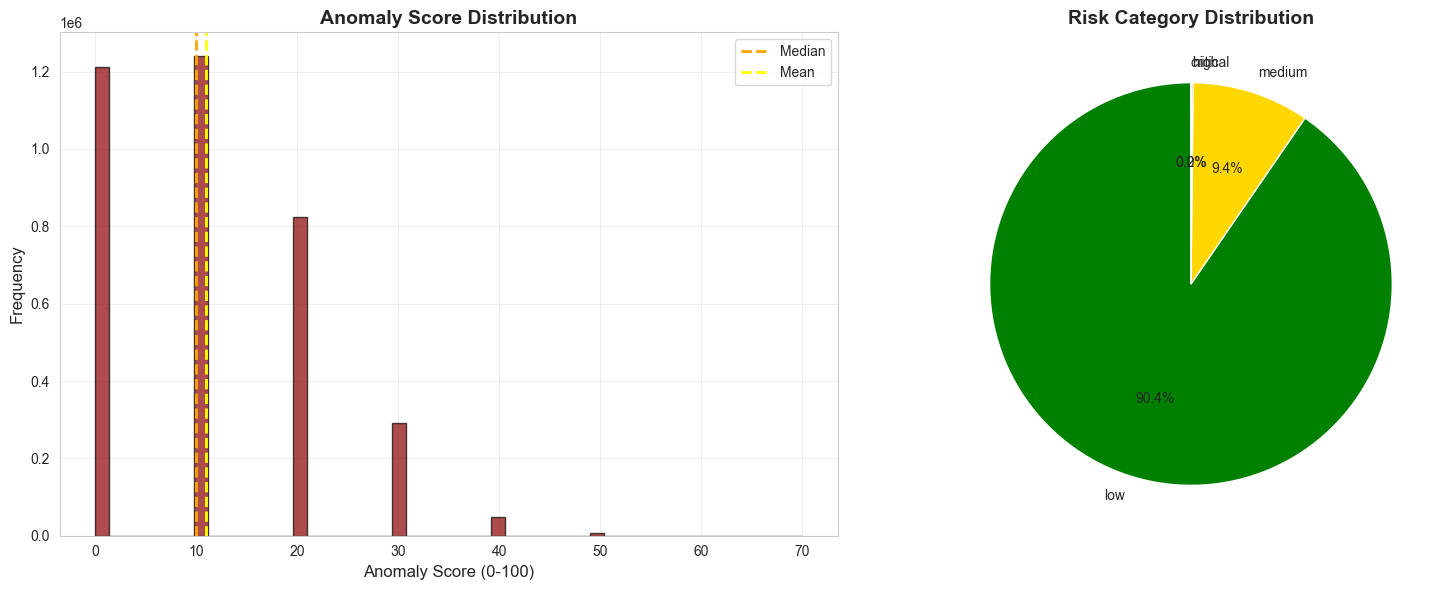


High/Critical risk tenders: 6,088
Percentage: 0.17%


In [19]:
# Visualize anomaly score distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist(df['anomaly_score_normalized'], bins=50, color='darkred', edgecolor='black', alpha=0.7)
axes[0].axvline(df['anomaly_score_normalized'].median(), color='orange', linestyle='--', linewidth=2, label='Median')
axes[0].axvline(df['anomaly_score_normalized'].mean(), color='yellow', linestyle='--', linewidth=2, label='Mean')
axes[0].set_xlabel('Anomaly Score (0-100)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Anomaly Score Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Risk category breakdown
risk_counts = df['risk_category'].value_counts()
colors_risk = ['green', 'gold', 'orange', 'darkred']
axes[1].pie(risk_counts, labels=risk_counts.index, autopct='%1.1f%%', colors=colors_risk, startangle=90)
axes[1].set_title('Risk Category Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nHigh/Critical risk tenders: {df[df['risk_category'].isin(['high', 'critical'])].shape[0]:,}")
print(f"Percentage: {df[df['risk_category'].isin(['high', 'critical'])].shape[0] / len(df) * 100:.2f}%")

## 8. Feature Summary and Export

In [20]:
# List all engineered features
print("="*80)
print("FEATURE ENGINEERING SUMMARY")
print("="*80)

# Get all numeric columns (potential features)
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nTotal numeric features: {len(numeric_features)}")
print("\nFeature categories:")

price_features = [f for f in numeric_features if 'price' in f.lower()]
competition_features = [f for f in numeric_features if any(x in f.lower() for x in ['bidder', 'competition', 'supplier_', 'organizer_'])]
temporal_features = [f for f in numeric_features if any(x in f.lower() for x in ['year', 'month', 'quarter', 'day', 'week', 'duration'])]
network_features = [f for f in numeric_features if any(x in f.lower() for x in ['concentration', 'diversity', 'centrality', 'network'])]
geographic_features = [f for f in numeric_features if 'region' in f.lower()]
anomaly_features = [f for f in numeric_features if 'anomaly' in f.lower() or 'risk' in f.lower()]

print(f"\n1. PRICE FEATURES ({len(price_features)}):")
for f in price_features[:10]:
    print(f"   - {f}")
if len(price_features) > 10:
    print(f"   ... and {len(price_features) - 10} more")

print(f"\n2. COMPETITION FEATURES ({len(competition_features)}):")
for f in competition_features[:10]:
    print(f"   - {f}")
if len(competition_features) > 10:
    print(f"   ... and {len(competition_features) - 10} more")

print(f"\n3. TEMPORAL FEATURES ({len(temporal_features)}):")
for f in temporal_features:
    print(f"   - {f}")

print(f"\n4. NETWORK FEATURES ({len(network_features)}):")
for f in network_features:
    print(f"   - {f}")

print(f"\n5. GEOGRAPHIC FEATURES ({len(geographic_features)}):")
for f in geographic_features[:10]:
    print(f"   - {f}")
if len(geographic_features) > 10:
    print(f"   ... and {len(geographic_features) - 10} more")

print(f"\n6. ANOMALY SCORES ({len(anomaly_features)}):")
for f in anomaly_features:
    print(f"   - {f}")

FEATURE ENGINEERING SUMMARY

Total numeric features: 72

Feature categories:

1. PRICE FEATURES (21):
   - price_change_abs
   - price_change_pct
   - price_increased
   - price_decreased
   - price_unchanged
   - price_extreme_increase
   - price_extreme_decrease
   - regional_mean_price
   - regional_median_price
   - regional_std_price
   ... and 11 more

2. COMPETITION FEATURES (33):
   - organizer_code
   - bidder_count
   - is_single_bidder
   - is_low_competition
   - is_healthy_competition
   - regional_avg_bidders
   - regional_median_bidders
   - regional_std_bidders
   - regional_single_bidder_rate
   - bidders_vs_regional_avg
   ... and 23 more

3. TEMPORAL FEATURES (9):
   - lot_announce_year
   - year
   - month
   - quarter
   - day_of_week
   - day_of_month
   - week_of_year
   - is_weekend
   - is_end_of_month

4. NETWORK FEATURES (4):
   - supplier_organizer_concentration
   - supplier_high_concentration
   - supplier_organizer_diversity
   - organizer_supplier_divers

In [21]:
# Save engineered dataset
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

output_file = output_dir / 'procurement_features.csv'

print(f"\nSaving engineered features to: {output_file}")
df.to_csv(output_file, index=False)

print(f"✓ Saved {len(df):,} rows with {len(df.columns)} columns")
print(f"  File size: {output_file.stat().st_size / 1024**2:.2f} MB")


Saving engineered features to: ..\data\processed\procurement_features.csv
✓ Saved 3,621,822 rows with 85 columns
  File size: 3419.39 MB


In [22]:
# Save feature list for reference
feature_list = pd.DataFrame({
    'feature_name': numeric_features,
    'data_type': [df[f].dtype for f in numeric_features],
    'missing_count': [df[f].isnull().sum() for f in numeric_features],
    'missing_pct': [(df[f].isnull().sum() / len(df) * 100).round(2) for f in numeric_features]
})

feature_list_file = output_dir / 'feature_list.csv'
feature_list.to_csv(feature_list_file, index=False)

print(f"\n✓ Feature list saved to: {feature_list_file}")


✓ Feature list saved to: ..\data\processed\feature_list.csv


In [23]:
# Display sample of high-risk tenders
print("\n" + "="*80)
print("SAMPLE HIGH-RISK TENDERS")
print("="*80)

high_risk = df[df['risk_category'] == 'critical'].sort_values('anomaly_score_normalized', ascending=False)

if len(high_risk) > 0:
    print(f"\nFound {len(high_risk):,} critical risk tenders")
    print("\nTop 5 most suspicious tenders:")
    
    display_cols = ['lot_id', 'anomaly_score_normalized', 'risk_category']
    
    # Add relevant columns if they exist
    for col in ['bidder_count', 'is_single_bidder', region_col if region_cols else None, 
                cpv_col if cpv_cols else None, final_price_col if final_price_col else None]:
        if col and col in df.columns:
            display_cols.append(col)
    
    display_cols = [c for c in display_cols if c in df.columns]
    
    print(high_risk[display_cols].head())
else:
    print("\nNo critical risk tenders found with current thresholds")


SAMPLE HIGH-RISK TENDERS

Found 2 critical risk tenders

Top 5 most suspicious tenders:
                            lot_id  anomaly_score_normalized risk_category  \
1181505  UA-2017-12-15-002498-b-L1                      70.0      critical   
3553808  UA-2019-12-18-001982-b-L1                      70.0      critical   

         bidder_count  is_single_bidder organizer_region  \
1181505           2.0                 0             Kyiv   
3553808           1.0                 1             Kyiv   

                                                   lot_cpv  lot_final_value  
1181505  44160000-9_Pipeline, piping, pipes, casing, tu...      549990000.0  
3553808               09130000-9_Petroleum and distillates      154116900.0  


## Summary

### Features Created:

**Price Features:**
- Price changes (absolute and percentage)
- Deviations from regional/category medians
- Z-scores and outlier flags

**Competition Features:**
- Bidder counts and competition levels
- Regional/category competition benchmarks
- Supplier/organizer win rates and patterns

**Temporal Features:**
- Time components (year, month, quarter, day)
- Budget cycle indicators (Q4, December, end-of-month)
- Deadline pressure (tender duration, rush flags)

**Network Features:**
- Supplier-organizer relationship strength
- Concentration and diversity metrics
- Market share indicators

**Geographic Features:**
- Multi-region supplier activity
- Regional market share and dominance

**Composite Scores:**
- Anomaly score (0-100)
- Risk categories (low, medium, high, critical)

### Next Steps:
✓ Model development with engineered features  
✓ Unsupervised learning (Isolation Forest, clustering)  
✓ Supervised learning (Random Forest, XGBoost)  
✓ Model evaluation and comparison  
✓ SHAP explainability analysis  